In [45]:
import torch
from torch import nn
from torchvision import datasets
import numpy as  np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [47]:
from torchvision import transforms

In [48]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [49]:
dataset = datasets.FashionMNIST(root="data",
                                train=True,
                                download=False,
                                transform=transform)
dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [50]:
X_train = dataset.data
y_train = dataset.targets

In [51]:
val_dataset = datasets.FashionMNIST(root="data",
                                    train=False,
                                    download=False,
                                    transform=transform)

In [52]:
X_test = val_dataset.data
y_test = val_dataset.targets

In [53]:
X_train.shape

torch.Size([60000, 28, 28])

In [54]:
class_names = dataset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [55]:
class_index = dataset.class_to_idx
class_index

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [56]:
train_dataloader = DataLoader(dataset=dataset,
                              batch_size=32,
                              shuffle=True)
test_dataloader = DataLoader(dataset=val_dataset,
                             batch_size=32,
                             shuffle=False)

In [57]:
class CNN_model(nn.Module):
    def __init__(self,
                 input_shape:int,
                 output_shape):
        super().__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=128*5*5,
                      out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256,
                      out_features=output_shape)
        )
        
    def forward(self, x):
        return self.classifier(self.conv_block(x))

In [58]:
model = CNN_model(input_shape=1,
                  output_shape=10)

In [59]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

In [60]:
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    return (correct/len(y_pred))*100

In [61]:
if torch.cuda.is_available():
    model.cuda()

In [62]:
def train_step(train_dataloader: DataLoader,
               model: nn.Module,
               optimizer: torch.optim.Optimizer,
               loss_fn: nn.Module,
               accuracy_fn,
               devive: torch.device = "cpu"):
    train_acc, train_loss = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        model.train()
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        acc = accuracy_fn(y_pred=y_hat.argmax(dim=1),
                          y_true=y)
        
        train_loss += loss
        train_acc += acc
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        model.eval()
    
    train_loss /= len(train_dataloader)    
    train_acc /= len(train_dataloader)
    
    print(f"Train loss: {train_loss}    |    Train acc: {train_acc}")

In [63]:
def test_step(test_dataloader: DataLoader,
              model: nn.Module,
              loss_fn: nn.Module,
              accuracy_fn,
              device: torch.device = "cpu"):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            loss = loss_fn(y_hat, y)
            acc = accuracy_fn(y_pred=y_hat.argmax(dim=1),
                              y_true=y)
            test_loss += loss
            test_acc += acc
            
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        print(f"Test loss: {test_loss}      |       Test acc: {test_acc}")
        

In [64]:
from tqdm.auto import tqdm

In [65]:
epochs = 5
for epoch in tqdm(range(epochs)):
    train_step(train_dataloader=train_dataloader,
               model=model,
               optimizer=optimizer,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               devive=device)

 20%|██        | 1/5 [01:07<04:31, 67.91s/it]

Train loss: 0.4210383892059326    |    Train acc: 84.525


 40%|████      | 2/5 [02:04<03:03, 61.02s/it]

Train loss: 0.27634063363075256    |    Train acc: 89.765


 60%|██████    | 3/5 [03:15<02:11, 65.70s/it]

Train loss: 0.23072242736816406    |    Train acc: 91.43833333333333


 80%|████████  | 4/5 [04:17<01:04, 64.15s/it]

Train loss: 0.19642680883407593    |    Train acc: 92.73833333333333


100%|██████████| 5/5 [05:30<00:00, 66.13s/it]

Train loss: 0.16664279997348785    |    Train acc: 93.75833333333334


In [66]:
test_step(test_dataloader=test_dataloader,
          model=model,
          loss_fn=loss_fn,
          accuracy_fn=accuracy_fn,
          device=device)

Test loss: 0.25133606791496277      |       Test acc: 91.29392971246007


In [67]:
from torchsummary import summary

In [70]:
summary(model, torch.zeros(size=(1, 1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 5, 5]           --
|    └─Conv2d: 2-1                       [-1, 64, 26, 26]          640
|    └─MaxPool2d: 2-2                    [-1, 64, 13, 13]          --
|    └─ReLU: 2-3                         [-1, 64, 13, 13]          --
|    └─Conv2d: 2-4                       [-1, 128, 11, 11]         73,856
|    └─MaxPool2d: 2-5                    [-1, 128, 5, 5]           --
|    └─ReLU: 2-6                         [-1, 128, 5, 5]           --
├─Sequential: 1-2                        [-1, 10]                  --
|    └─Flatten: 2-7                      [-1, 3200]                --
|    └─Linear: 2-8                       [-1, 256]                 819,456
|    └─ReLU: 2-9                         [-1, 256]                 --
|    └─Linear: 2-10                      [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 5, 5]           --
|    └─Conv2d: 2-1                       [-1, 64, 26, 26]          640
|    └─MaxPool2d: 2-2                    [-1, 64, 13, 13]          --
|    └─ReLU: 2-3                         [-1, 64, 13, 13]          --
|    └─Conv2d: 2-4                       [-1, 128, 11, 11]         73,856
|    └─MaxPool2d: 2-5                    [-1, 128, 5, 5]           --
|    └─ReLU: 2-6                         [-1, 128, 5, 5]           --
├─Sequential: 1-2                        [-1, 10]                  --
|    └─Flatten: 2-7                      [-1, 3200]                --
|    └─Linear: 2-8                       [-1, 256]                 819,456
|    └─ReLU: 2-9                         [-1, 256]                 --
|    └─Linear: 2-10                      [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0


In [84]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))

(-0.5, 27.5, 27.5, -0.5)

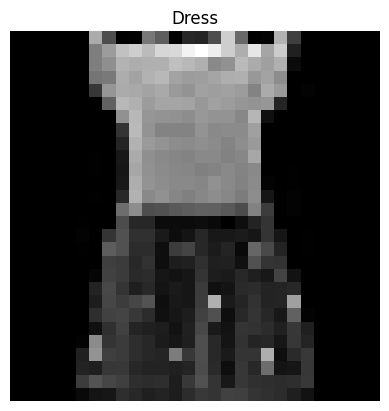

In [88]:
# Show a sample
random_idx = torch.randint(0, len(train_features_batch), size= [1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap= "gray")
plt.title(class_names[label])
plt.axis(False)